In [3]:
import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.datasets.folder import default_loader
from tqdm import tqdm

# 📌 Parametry
DATA_DIR = "data/cats"  # <-- podmień
IMG_SIZE = 64
BATCH_SIZE = 128
NUM_EPOCHS = 30
LR = 2e-4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 📁 Dataset
class SimpleImageDataset(Dataset):
    def __init__(self, folder, transform):
        self.paths = [os.path.join(folder, f) for f in os.listdir(folder) if ('cat' in f or 'dog' in f)]
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        img = default_loader(self.paths[idx]).convert("RGB")
        return self.transform(img)

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = SimpleImageDataset(DATA_DIR, transform)
loader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---- Encoder ----
class Encoder(nn.Module):
    def __init__(self, in_channels=3, hidden_dim=128, z_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(hidden_dim, z_dim, 1)
        )

    def forward(self, x):
        return self.net(x)

# ---- Decoder ----
class Decoder(nn.Module):
    def __init__(self, z_dim=64, hidden_dim=128, out_channels=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.ConvTranspose2d(z_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, hidden_dim, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(hidden_dim, out_channels, 3, 1, 1)
        )

    def forward(self, x):
        return self.net(x)

# ---- Vector Quantizer ----
class VectorQuantizer(nn.Module):
    def __init__(self, num_embeddings, embedding_dim, beta=0.25):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings, embedding_dim)
        self.embedding.weight.data.uniform_(-1/num_embeddings, 1/num_embeddings)
        self.beta = beta

    def forward(self, z):
        z_perm = z.permute(0, 2, 3, 1).contiguous()
        flat_z = z_perm.view(-1, z.shape[1])

        dists = (
            flat_z.pow(2).sum(1, keepdim=True)
            - 2 * flat_z @ self.embedding.weight.t()
            + self.embedding.weight.pow(2).sum(1)
        )
        indices = dists.argmin(1)
        quantized = self.embedding(indices).view(z_perm.shape)
        quantized = quantized.permute(0, 3, 1, 2)

        loss = F.mse_loss(quantized.detach(), z) + self.beta * F.mse_loss(quantized, z.detach())
        quantized = z + (quantized - z).detach()
        return quantized, loss, indices.view(z_perm.shape[0], z_perm.shape[1], z_perm.shape[2])

# ---- VQ-VAE ----
class VQVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.vq = VectorQuantizer(num_embeddings=512, embedding_dim=64)
        self.decoder = Decoder()

    def forward(self, x):
        z = self.encoder(x)
        quantized, loss_vq, indices = self.vq(z)
        recon = self.decoder(quantized)
        return recon, loss_vq, indices


class MaskedConv2d(nn.Conv2d):
    def __init__(self, mask_type, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert mask_type in ['A', 'B'], "mask_type must be 'A' or 'B'"
        self.register_buffer("mask", self.weight.data.clone())
        _, _, h, w = self.weight.size()
        self.mask.fill_(1)
        yc, xc = h // 2, w // 2

        self.mask[:, :, yc + 1:] = 0
        self.mask[:, :, yc, xc + (mask_type == 'B'):] = 0

    def forward(self, x):
        self.weight.data *= self.mask
        return super().forward(x)

class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReLU(),
            MaskedConv2d('B', channels, channels, 3, padding=1),
            nn.ReLU(),
            MaskedConv2d('B', channels, channels, 1)
        )

    def forward(self, x):
        return x + self.block(x)

class PixelCNN(nn.Module):
    def __init__(self, num_embeddings, input_shape=(8, 8), hidden_dim=128, n_residual=7):
        super().__init__()
        self.H, self.W = input_shape

        self.start = MaskedConv2d('A', 1, hidden_dim, kernel_size=7, padding=3)
        self.res_blocks = nn.Sequential(*[
            ResidualBlock(hidden_dim) for _ in range(n_residual)
        ])
        self.output = nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(hidden_dim, hidden_dim, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(hidden_dim, num_embeddings, kernel_size=1)
        )

    def forward(self, x):
        x = self.start(x)
        x = self.res_blocks(x)
        return self.output(x)



In [5]:
model_vqvae = VQVAE().to(device)
optimizer = torch.optim.Adam(model_vqvae.parameters(), lr=LR)

for epoch in range(NUM_EPOCHS):
    model_vqvae.train()
    total_loss = 0.0
    for batch in tqdm(loader, desc=f"VQ-VAE Epoch {epoch+1}/{NUM_EPOCHS}"):
        batch = batch.to(device)

        recon, loss_vq, _ = model_vqvae(batch)
        recon_loss = F.mse_loss(recon, batch)
        loss = recon_loss + loss_vq

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] | Total Loss: {avg_loss:.4f}")


VQ-VAE Epoch 1/30: 100%|██████████| 234/234 [00:17<00:00, 13.15it/s]


Epoch [1/30] | Total Loss: 1.6872


VQ-VAE Epoch 2/30: 100%|██████████| 234/234 [00:17<00:00, 13.45it/s]


Epoch [2/30] | Total Loss: 0.2985


VQ-VAE Epoch 3/30: 100%|██████████| 234/234 [00:17<00:00, 13.56it/s]


Epoch [3/30] | Total Loss: 0.1467


VQ-VAE Epoch 4/30: 100%|██████████| 234/234 [00:17<00:00, 13.53it/s]


Epoch [4/30] | Total Loss: 0.1014


VQ-VAE Epoch 5/30: 100%|██████████| 234/234 [00:17<00:00, 13.64it/s]


Epoch [5/30] | Total Loss: 0.0604


VQ-VAE Epoch 6/30: 100%|██████████| 234/234 [00:17<00:00, 13.63it/s]


Epoch [6/30] | Total Loss: 0.0498


VQ-VAE Epoch 7/30: 100%|██████████| 234/234 [00:17<00:00, 13.68it/s]


Epoch [7/30] | Total Loss: 0.0444


VQ-VAE Epoch 8/30: 100%|██████████| 234/234 [00:17<00:00, 13.75it/s]


Epoch [8/30] | Total Loss: 0.0394


VQ-VAE Epoch 9/30: 100%|██████████| 234/234 [00:17<00:00, 13.31it/s]


Epoch [9/30] | Total Loss: 0.0365


VQ-VAE Epoch 10/30: 100%|██████████| 234/234 [00:16<00:00, 13.89it/s]


Epoch [10/30] | Total Loss: 0.0339


VQ-VAE Epoch 11/30: 100%|██████████| 234/234 [00:16<00:00, 13.77it/s]


Epoch [11/30] | Total Loss: 0.0318


VQ-VAE Epoch 12/30: 100%|██████████| 234/234 [00:17<00:00, 13.52it/s]


Epoch [12/30] | Total Loss: 0.0302


VQ-VAE Epoch 13/30: 100%|██████████| 234/234 [00:17<00:00, 13.26it/s]


Epoch [13/30] | Total Loss: 0.0285


VQ-VAE Epoch 14/30: 100%|██████████| 234/234 [00:17<00:00, 13.59it/s]


Epoch [14/30] | Total Loss: 0.0275


VQ-VAE Epoch 15/30: 100%|██████████| 234/234 [00:18<00:00, 12.77it/s]


Epoch [15/30] | Total Loss: 0.0267


VQ-VAE Epoch 16/30: 100%|██████████| 234/234 [00:17<00:00, 13.24it/s]


Epoch [16/30] | Total Loss: 0.0257


VQ-VAE Epoch 17/30: 100%|██████████| 234/234 [00:17<00:00, 13.56it/s]


Epoch [17/30] | Total Loss: 0.0250


VQ-VAE Epoch 18/30: 100%|██████████| 234/234 [00:17<00:00, 13.53it/s]


Epoch [18/30] | Total Loss: 0.0246


VQ-VAE Epoch 19/30: 100%|██████████| 234/234 [00:17<00:00, 13.06it/s]


Epoch [19/30] | Total Loss: 0.0242


VQ-VAE Epoch 20/30: 100%|██████████| 234/234 [00:17<00:00, 13.35it/s]


Epoch [20/30] | Total Loss: 0.0241


VQ-VAE Epoch 21/30: 100%|██████████| 234/234 [00:17<00:00, 13.47it/s]


Epoch [21/30] | Total Loss: 0.0238


VQ-VAE Epoch 22/30: 100%|██████████| 234/234 [00:17<00:00, 13.28it/s]


Epoch [22/30] | Total Loss: 0.0232


VQ-VAE Epoch 23/30: 100%|██████████| 234/234 [00:17<00:00, 13.33it/s]


Epoch [23/30] | Total Loss: 0.0227


VQ-VAE Epoch 24/30: 100%|██████████| 234/234 [00:17<00:00, 13.56it/s]


Epoch [24/30] | Total Loss: 0.0223


VQ-VAE Epoch 25/30: 100%|██████████| 234/234 [00:17<00:00, 13.60it/s]


Epoch [25/30] | Total Loss: 0.0218


VQ-VAE Epoch 26/30: 100%|██████████| 234/234 [00:17<00:00, 13.58it/s]


Epoch [26/30] | Total Loss: 0.0215


VQ-VAE Epoch 27/30: 100%|██████████| 234/234 [00:17<00:00, 13.59it/s]


Epoch [27/30] | Total Loss: 0.0211


VQ-VAE Epoch 28/30: 100%|██████████| 234/234 [00:17<00:00, 13.59it/s]


Epoch [28/30] | Total Loss: 0.0207


VQ-VAE Epoch 29/30: 100%|██████████| 234/234 [00:17<00:00, 13.58it/s]


Epoch [29/30] | Total Loss: 0.0203


VQ-VAE Epoch 30/30: 100%|██████████| 234/234 [00:17<00:00, 13.59it/s]

Epoch [30/30] | Total Loss: 0.0201


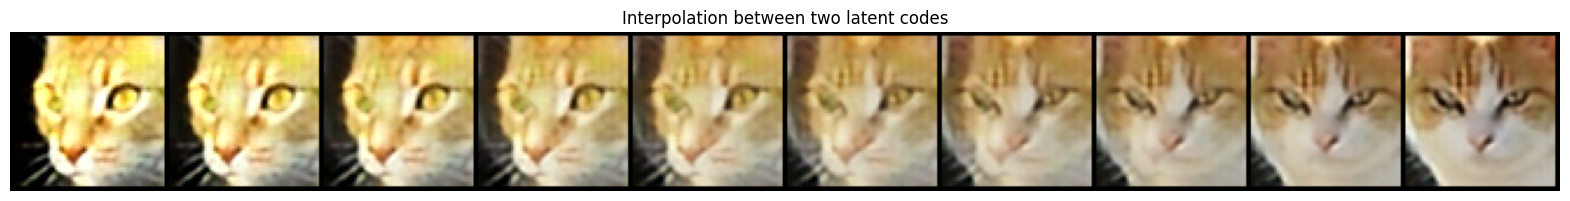

In [6]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import numpy as np

def interpolate_latents(z1, z2, steps=8):
    return [z1 * (1 - alpha) + z2 * alpha for alpha in np.linspace(0, 1, steps + 2)]

model_vqvae.eval()
with torch.no_grad():
    imgs = next(iter(loader)).to(device)[:2]
    z1 = model_vqvae.encoder(imgs[0].unsqueeze(0))
    z2 = model_vqvae.encoder(imgs[1].unsqueeze(0))
    interpolated = interpolate_latents(z1, z2)
    decoded = [model_vqvae.decoder(z) for z in interpolated]
    decoded = torch.cat(decoded)
    decoded = (decoded * 0.5 + 0.5).clamp(0, 1)
    grid = make_grid(decoded, nrow=10)
    plt.figure(figsize=(20, 4))
    plt.imshow(grid.permute(1, 2, 0).cpu())
    plt.axis("off")
    plt.title("Interpolation between two latent codes")
    plt.show()


In [7]:
model_pixelcnn = PixelCNN(num_embeddings=512, input_shape=(8, 8), hidden_dim=128).to(device)
optimizer = torch.optim.Adam(model_pixelcnn.parameters(), lr=1e-3)

model_vqvae.eval()  # tylko encoder i VQ

for epoch in range(NUM_EPOCHS):
    model_pixelcnn.train()
    total_loss = 0.0

    pbar = tqdm(loader, desc=f"PixelCNN Epoch {epoch+1}/{NUM_EPOCHS}")
    for batch in pbar:
        batch = batch.to(device)

        with torch.no_grad():
            z = model_vqvae.encoder(batch)
            _, _, indices = model_vqvae.vq(z)

        inputs = indices.unsqueeze(1).float()  # (B, 1, H, W)
        targets = indices.long()               # (B, H, W)

        logits = model_pixelcnn(inputs)
        loss = F.cross_entropy(logits, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(loader)
    print(f"PixelCNN Epoch {epoch+1} | Avg Loss: {avg_loss:.4f}")


PixelCNN Epoch 1/30: 100%|██████████| 234/234 [00:16<00:00, 14.45it/s, loss=4.47]


PixelCNN Epoch 1 | Avg Loss: 5.3004


PixelCNN Epoch 2/30: 100%|██████████| 234/234 [00:16<00:00, 14.14it/s, loss=4.49]


PixelCNN Epoch 2 | Avg Loss: 4.4721


PixelCNN Epoch 3/30: 100%|██████████| 234/234 [00:16<00:00, 14.20it/s, loss=4.52]


PixelCNN Epoch 3 | Avg Loss: 4.4434


PixelCNN Epoch 4/30: 100%|██████████| 234/234 [00:16<00:00, 14.24it/s, loss=4.45]


PixelCNN Epoch 4 | Avg Loss: 4.4188


PixelCNN Epoch 5/30: 100%|██████████| 234/234 [00:16<00:00, 14.22it/s, loss=4.18]


PixelCNN Epoch 5 | Avg Loss: 4.3894


PixelCNN Epoch 6/30: 100%|██████████| 234/234 [00:16<00:00, 14.29it/s, loss=4.41]


PixelCNN Epoch 6 | Avg Loss: 4.3544


PixelCNN Epoch 7/30: 100%|██████████| 234/234 [00:16<00:00, 14.29it/s, loss=4.31]


PixelCNN Epoch 7 | Avg Loss: 4.3045


PixelCNN Epoch 8/30: 100%|██████████| 234/234 [00:17<00:00, 13.62it/s, loss=4.16]


PixelCNN Epoch 8 | Avg Loss: 4.2668


PixelCNN Epoch 9/30: 100%|██████████| 234/234 [00:16<00:00, 13.82it/s, loss=4.15]


PixelCNN Epoch 9 | Avg Loss: 4.2362


PixelCNN Epoch 10/30: 100%|██████████| 234/234 [00:17<00:00, 13.74it/s, loss=4.37]


PixelCNN Epoch 10 | Avg Loss: 4.2083


PixelCNN Epoch 11/30: 100%|██████████| 234/234 [00:17<00:00, 13.67it/s, loss=4.15]


PixelCNN Epoch 11 | Avg Loss: 4.1751


PixelCNN Epoch 12/30: 100%|██████████| 234/234 [00:16<00:00, 13.93it/s, loss=4.04]


PixelCNN Epoch 12 | Avg Loss: 4.1520


PixelCNN Epoch 13/30: 100%|██████████| 234/234 [00:16<00:00, 14.04it/s, loss=4.11]


PixelCNN Epoch 13 | Avg Loss: 4.1298


PixelCNN Epoch 14/30: 100%|██████████| 234/234 [00:16<00:00, 14.38it/s, loss=4.07]


PixelCNN Epoch 14 | Avg Loss: 4.1090


PixelCNN Epoch 15/30: 100%|██████████| 234/234 [00:17<00:00, 13.64it/s, loss=4.17]


PixelCNN Epoch 15 | Avg Loss: 4.0885


PixelCNN Epoch 16/30: 100%|██████████| 234/234 [00:17<00:00, 13.60it/s, loss=4.2] 


PixelCNN Epoch 16 | Avg Loss: 4.0767


PixelCNN Epoch 17/30: 100%|██████████| 234/234 [00:17<00:00, 13.72it/s, loss=3.99]


PixelCNN Epoch 17 | Avg Loss: 4.0457


PixelCNN Epoch 18/30: 100%|██████████| 234/234 [00:16<00:00, 14.41it/s, loss=4.04]


PixelCNN Epoch 18 | Avg Loss: 4.0305


PixelCNN Epoch 19/30: 100%|██████████| 234/234 [00:16<00:00, 14.25it/s, loss=4.11]


PixelCNN Epoch 19 | Avg Loss: 4.0107


PixelCNN Epoch 20/30: 100%|██████████| 234/234 [00:16<00:00, 14.37it/s, loss=4.04]


PixelCNN Epoch 20 | Avg Loss: 3.9871


PixelCNN Epoch 21/30: 100%|██████████| 234/234 [00:16<00:00, 14.24it/s, loss=3.99]


PixelCNN Epoch 21 | Avg Loss: 3.9742


PixelCNN Epoch 22/30: 100%|██████████| 234/234 [00:15<00:00, 14.84it/s, loss=3.99]


PixelCNN Epoch 22 | Avg Loss: 3.9590


PixelCNN Epoch 23/30: 100%|██████████| 234/234 [00:15<00:00, 14.79it/s, loss=3.54]


PixelCNN Epoch 23 | Avg Loss: 3.9448


PixelCNN Epoch 24/30: 100%|██████████| 234/234 [00:15<00:00, 14.81it/s, loss=4.02]


PixelCNN Epoch 24 | Avg Loss: 3.9330


PixelCNN Epoch 25/30: 100%|██████████| 234/234 [00:15<00:00, 14.71it/s, loss=4.03]


PixelCNN Epoch 25 | Avg Loss: 3.9169


PixelCNN Epoch 26/30: 100%|██████████| 234/234 [00:15<00:00, 14.84it/s, loss=3.88]


PixelCNN Epoch 26 | Avg Loss: 3.9011


PixelCNN Epoch 27/30: 100%|██████████| 234/234 [00:16<00:00, 14.27it/s, loss=3.99]


PixelCNN Epoch 27 | Avg Loss: 3.8886


PixelCNN Epoch 28/30: 100%|██████████| 234/234 [00:15<00:00, 14.91it/s, loss=3.96]


PixelCNN Epoch 28 | Avg Loss: 3.8776


PixelCNN Epoch 29/30: 100%|██████████| 234/234 [00:16<00:00, 14.55it/s, loss=3.63]


PixelCNN Epoch 29 | Avg Loss: 3.8651


PixelCNN Epoch 30/30: 100%|██████████| 234/234 [00:15<00:00, 14.70it/s, loss=3.83]

PixelCNN Epoch 30 | Avg Loss: 3.8577


In [17]:
import torch
import torch.nn.functional as F

@torch.no_grad()
def generate_images_tensor(vqvae, pixelcnn, device='cuda', num_samples=4):

        vqvae.eval()
        pixelcnn.eval()

        codebook_size = vqvae.vq.embedding.num_embeddings
        H, W = pixelcnn.H, pixelcnn.W

        # 1. Generowanie map indeksów
        sampled_indices = torch.zeros((num_samples, H, W), dtype=torch.long).to(device)
        for i in range(H):
            for j in range(W):
                logits = pixelcnn(sampled_indices.unsqueeze(1).float())  # (N, codebook_size, H, W)
                probs = F.softmax(logits[:, :, i, j], dim=-1)  # (N, codebook_size)
                sampled = torch.multinomial(probs, num_samples=1).squeeze(-1)  # (N,)
                sampled_indices[:, i, j] = sampled

        # 2. Konwersja indeksów do osadzeń (embeddingów)
        quantized = vqvae.vq.embedding(sampled_indices.view(-1))  # (N*H*W, D)
        D = quantized.shape[1]
        quantized = quantized.view(num_samples, H, W, D).permute(0, 3, 1, 2).contiguous()  # (N, D, H, W)

        # 3. Dekodowanie osadzeń do obrazów
        recon_images = vqvae.decoder(quantized)  # (N, 3, H', W')

        return recon_images.clamp(0, 1)

In [ ]:
# Przygotowanie modeli
vqvae = VQVAE().to(device)
pixelcnn = PixelCNN(num_embeddings=512).to(device)

# Załaduj wagi, jeśli masz
# vqvae.load_state_dict(torch.load("vqvae.pth"))
# pixelcnn.load_state_dict(torch.load("pixelcnn.pth"))

# Generuj obrazy jako macierz (tensor)
images = generate_images_tensor(vqvae, pixelcnn, device='cuda', num_samples=8)
print(images.shape)  # powinno zwrócić torch.Size([8, 3, H, W])

# Na przykład: torch.Size([8, 3, 32, 32])


NameError: name 'vqvae' is not defined

In [14]:
model_pixelcnn.eval()
model_vqvae.eval()

with torch.no_grad():
    sampled_indices = model_pixelcnn.sample((24, 8, 8), device=device)  # shape: (B, 1, 8, 8)

    embedding_weights = model_vqvae.vq.embedding.weight
    quantized = embedding_weights[sampled_indices.squeeze(1)]  # (B, 8, 8, 64)
    quantized = quantized.permute(0, 3, 1, 2).contiguous()  # (B, 64, 8, 8)

    generated_images = model_vqvae.decoder(quantized)  # (B, 3, H, W)


AttributeError: 'PixelCNN' object has no attribute 'sample'

In [13]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Zakładamy, że `generated_images` to tensor (B, 3, H, W)
# i wartości są w przedziale [-1, 1]

# ✅ 1. Odnormalizacja do [0, 1]
images = (generated_images.clamp(-1, 1) + 1) / 2

# ✅ 2. Stworzenie siatki (gridu)
grid = make_grid(images, nrow=8, padding=2)

# ✅ 3. Zamiana permutacji do formatu HWC
grid_np = grid.permute(1, 2, 0).cpu().numpy()

# ✅ 4. Wyświetlenie
plt.figure(figsize=(20,20))
plt.imshow(grid_np)
plt.axis('off')
plt.title("Generated cats")
plt.show()


NameError: name 'generated_images' is not defined